## Projekt SNiUG
### Zastosowanie sieci rekurencyjnych do analizy stanu psychicznego w tekstach
Barbara Kania

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from collections import Counter
import spacy
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

#### 1.Dane

In [42]:
data = pd.read_csv("dataset.csv")

print(data.head())
emotion_counts = data['status'].value_counts()
print(data['status'].value_counts())  

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


1.1 Wizulizacja liczby przypadków danej klasy

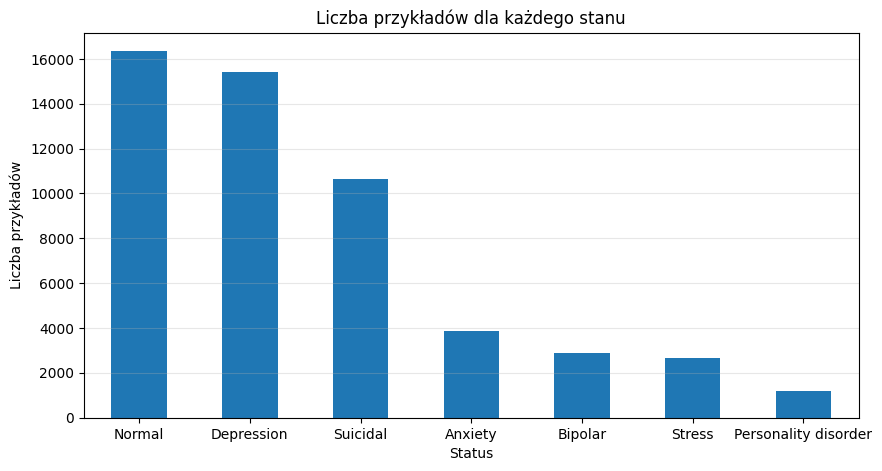

In [44]:
plt.figure(figsize=(10, 5))
emotion_counts.plot(kind='bar')
plt.title('Liczba przykładów dla każdego stanu')
plt.xlabel('Status')
plt.ylabel('Liczba przykładów')
plt.xticks(rotation=360)
plt.grid(axis='y', alpha=0.3)
plt.show()

1.2 Sprawdzenie braków danych

In [45]:
print(data.isnull().sum()) 
print(data[data.isnull().any(axis=1)]) 

Unnamed: 0      0
statement     362
status          0
dtype: int64
       Unnamed: 0 statement   status
293           293       NaN  Anxiety
572           572       NaN  Anxiety
595           595       NaN  Anxiety
1539         1539       NaN   Normal
2448         2448       NaN   Normal
...           ...       ...      ...
52838       52838       NaN  Anxiety
52870       52870       NaN  Anxiety
52936       52936       NaN  Anxiety
53010       53010       NaN  Anxiety
53031       53031       NaN  Anxiety

[362 rows x 3 columns]


In [46]:
df= data.dropna()
df.count

<bound method DataFrame.count of        Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

[52681 rows x 3 columns]>

1.4 Statystyki długości tekstów


In [47]:
df['text_length'] = df['statement'].apply(len)
print(df['text_length'].describe())  

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: text_length, dtype: float64


C:\Users\Basia\AppData\Local\Temp\ipykernel_11296\2348480121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['statement'].apply(len)


#### 2. Przygotowanie danych

2.1 Załadowanie modelu językowego spaCy oraz czyszczenie tesktu

In [48]:
nlp = spacy.load("en_core_web_sm")
def clean_text(text):
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^\w\s]', '', text) 
    doc = nlp(text.lower())
    cleaned_text = " ".join(
        [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    )
    return cleaned_text

df['cleaned_statement'] = df['statement'].apply(clean_text)
X = df['cleaned_statement']

C:\Users\Basia\AppData\Local\Temp\ipykernel_11296\2494002991.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_statement'] = df['statement'].apply(clean_text)


2.2 Podział na wejście (tekst) i wyjście (emocje) oraz tokenizacja


In [49]:
X = df['cleaned_statement']
y = df['status']

# Tokenizacja tekstu
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=50, padding='post', truncating='post')

2.3 Podział danych

In [50]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

2.4 Oversampling

In [51]:
print("Rozkład klas przed oversamplingiem:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Rozkład klas po oversamplingu:", Counter(y_train_resampled))

Rozkład klas przed oversamplingiem: Counter({3: 13035, 2: 12388, 6: 8494, 0: 3086, 1: 2250, 5: 2051, 4: 840})
Rozkład klas po oversamplingu: Counter({6: 13035, 2: 13035, 4: 13035, 5: 13035, 3: 13035, 0: 13035, 1: 13035})


#### 3. Trenowanie modelu

In [12]:
# Funkcja  budowy modelu 
def build_model(lr, lstm_units, dropout_rate):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(dropout_rate),
        Bidirectional(LSTM(lstm_units)),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Parametry do testowania
learning_rates = [0.001, 0.0005, 0.0001]
lstm_units = [64, 128, 256]
dropout_rates = [0.2, 0.4]
batch_sizes = [16, 32, 64]
epochs = [3, 5]
results = []

# Testowanie
for lr in learning_rates:
    for units in lstm_units:
        for dropout in dropout_rates:
            for batch_size in batch_sizes:
                for epoch in epochs:
                    print(f"Testing: LR={lr}, LSTM Units={units}, Dropout={dropout}, Batch Size={batch_size}, Epochs={epoch}")
                    
                    # Budowa modelu
                    model = build_model(lr, units, dropout)
                    
                    # Trening modelu
                    history = model.fit(
                        X_train_resampled, y_train_resampled,  
                        validation_data=(X_val, y_val),
                        epochs=epoch,
                        batch_size=batch_size,
                        verbose=0  
                    )
                    
                    # Ewaluacja modelu
                    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
                    y_pred = model.predict(X_test)  
                    y_pred_classes = np.argmax(y_pred, axis=1) 
                    
                    precision = precision_score(y_test, y_pred_classes, average='micro')
                    recall = recall_score(y_test, y_pred_classes, average='micro')
                    f1 = f1_score(y_test, y_pred_classes, average='micro')
                    print(f"Test Accuracy: {test_accuracy}")
                    
                    results.append({
                        "learning_rate": lr,
                        "lstm_units": units,
                        "dropout": dropout,
                        "batch_size": batch_size,
                        "epochs": epoch,
                        "test_accuracy": test_accuracy,
                        "test_loss": test_loss,
                        "precision": precision,  
                        "recall": recall,        
                        "f1_score": f1,         
                    })

results_df = pd.DataFrame(results)


Testing: LR=0.001, LSTM Units=64, Dropout=0.2, Batch Size=16, Epochs=3
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
Test Accuracy: 0.7303093671798706
Testing: LR=0.001, LSTM Units=64, Dropout=0.2, Batch Size=16, Epochs=5
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
Test Accuracy: 0.7147466540336609
Testing: LR=0.001, LSTM Units=64, Dropout=0.2, Batch Size=32, Epochs=3
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step
Test Accuracy: 0.748149573802948
Testing: LR=0.001, LSTM Units=64, Dropout=0.2, Batch Size=32, Epochs=5
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Test Accuracy: 0.7261340022087097
Testing: LR=0.001, LSTM Units=64, Dropout=0.2, Batch Size=64, Epochs=3
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Test Accuracy: 0.7394192218780518
Testing: LR=0.001, LSTM Units=64, Dropout=0.2, Batch Size=64, Epochs=5
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Test Accuracy: 0.7284114360809326
Testing: LR=0.001, LSTM Units=64, Dropout=0.4, Batch Size=16, Epochs=3
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
Test A

3.1 Wyniki 

In [ ]:
print(results_df)
sorted_results = results_df.sort_values(by="test_accuracy", ascending=False)
results_df.to_csv("hyperparameter_results.csv", index=False)

#### 4. Wykorzystanie najlepszego modelu 



In [76]:

model = build_model(0.001, 256, 0.2)
                    
history = model.fit(
                        X_train_resampled, y_train_resampled, 
                        validation_data=(X_val, y_val),
                        epochs=3,
                        batch_size=16,
                        verbose=0  
                    )


In [77]:
print(test_accuracy)


0.7646612524986267


4.1 Ewaluacja modelu


In [78]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)  
y_pred_classes = np.argmax(y_pred, axis=1)  


165/165 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step


4.2 Wizualizacja wyników

In [79]:
class_names = ["Normal", "Depression", "Suicidal", "Anxiety", "Bipolar", "Stress", "Personality disorder"]
num_classes = len(class_names)

Generowanie macierzy pomyłek


In [66]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predykcje')
    plt.ylabel('Rzeczywiste wartości')
    plt.title('Macierz pomyłek')
    plt.show()

Generowanie wykresu ROC-AUC

In [67]:
def plot_roc_curve(y_true, y_probs, num_classes):
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Krzywa ROC dla każdej klasy')
    plt.legend()
    plt.show()

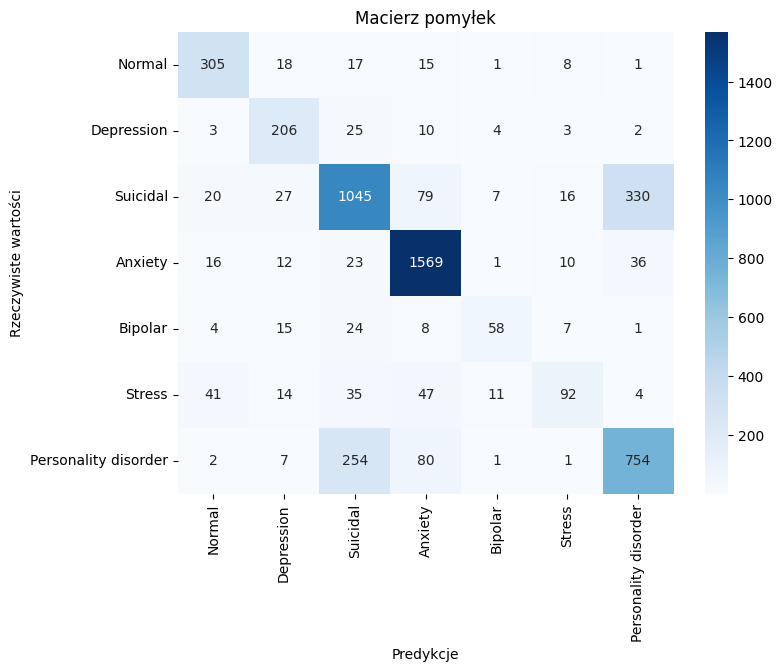

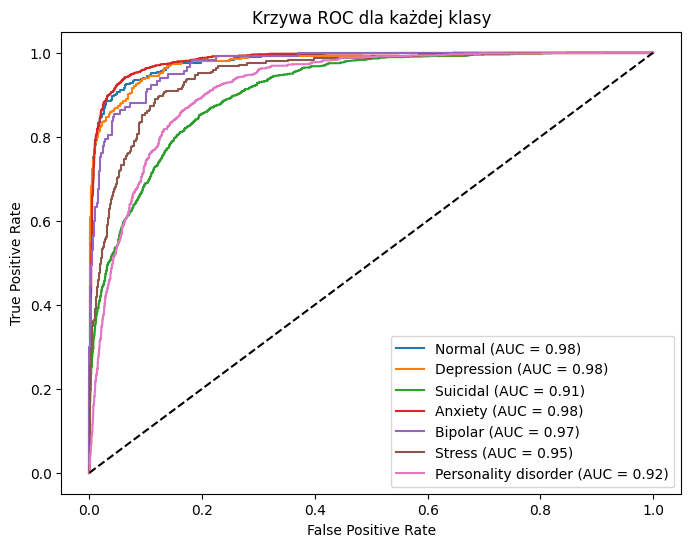

In [68]:
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true_classes = np.argmax(y_test_one_hot, axis=1)  


plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
plot_roc_curve(y_test_one_hot, y_pred, num_classes=num_classes)

Wykres dokładności modelu podczas treningu

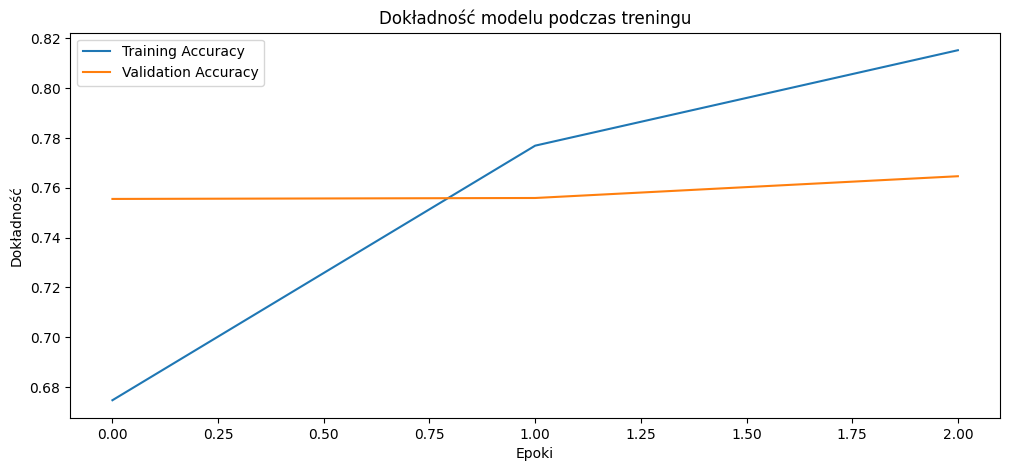

In [69]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.title('Dokładność modelu podczas treningu')
plt.show()

Wykres przedstawiający stratę modelu podczas treningu

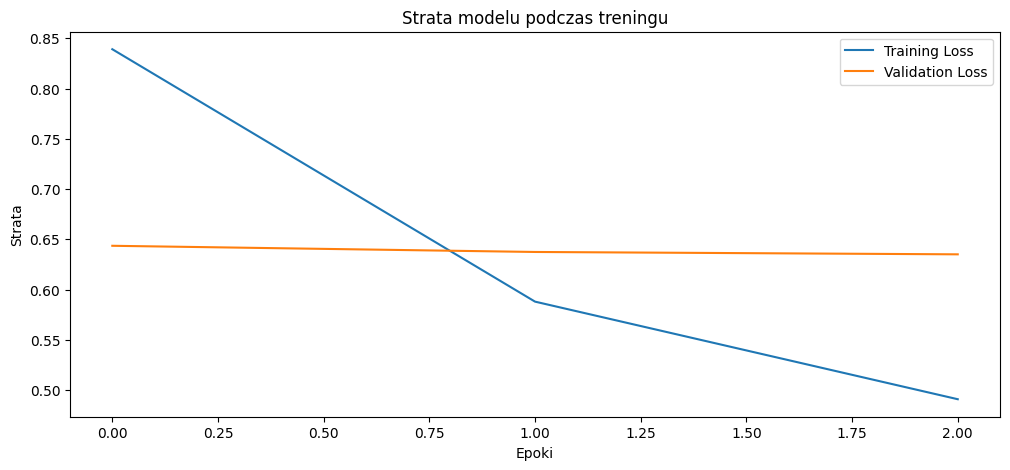

In [70]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.title('Strata modelu podczas treningu')
plt.show()

#### 5. Testowanie predykcji 

Przykładowe teksty z predykcjami i rzeczywistymi etykietami

In [88]:
sample_texts = X_test[:10] 
sample_true_labels = y_test[:10]
sample_pred_labels = y_pred_classes[:10]

In [89]:
decoded_texts = [
    " ".join([tokenizer.index_word.get(idx, "") for idx in sample if idx != 0]) 
    for sample in X_test[:10]
]

true_labels = label_encoder.inverse_transform(y_test[:10])

pred_labels = label_encoder.inverse_transform(y_pred_classes[:10])

df_results = pd.DataFrame({
    "Tekst": decoded_texts,
    "Rzeczywista Klasa": true_labels,
    "Przewidywana Klasa": pred_labels
})
df_results

,Tekst,Rzeczywista Klasa,Przewidywana Klasa
0,attention leave want die know cry day miss lea...,Depression,Suicidal
1,kind update post feel like quit college soon y...,Depression,Depression
2,bring great <OOV> cancel fast,Normal,Normal
3,calm storm year half ago long <OOV> episode fo...,Bipolar,Bipolar
4,invite interact respond unpleasant way not imm...,Normal,Normal
5,<OOV> <OOV> point consider late late try late ...,Personality disorder,Personality disorder
6,worried <OOV> poisoning m college student volu...,Anxiety,Anxiety
7,truth mitigate symptom ptsd psychotherapy dbt ...,Normal,Bipolar
8,context rough childhood remember course stray ...,Suicidal,Suicidal
9,deal make mistake like break stuff s forget im...,Personality disorder,Stress
